In [1]:
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchtune.modules import RotaryPositionalEmbeddings as rpe
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
batch_size = 256

In [5]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [6]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [7]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [8]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [9]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [10]:
data = torch.tensor(encode(text))
n = int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]


In [11]:
class TinyDataSet(Dataset):
    def __init__(self, data, context_size = 8):
        self.x = []
        self.y = []
        context_blocks_number = data.shape[0] // context_size
        for i in range(context_blocks_number):
            left = i * context_size
            right = left + context_size
            if right >= data.shape[0]:
                break
            self.x.append(data[left : right])
            self.y.append(data[left+1:right+1])
        self.x = torch.stack(self.x)
        self.y = torch.stack(self.y)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.x.shape[0]
        

In [12]:

train_dataset = TinyDataSet(train_data)
val_dataset = TinyDataSet(val_data)
print(len(train_dataset), len(val_dataset))

111539 27884


In [13]:
train_loader = DataLoader(dataset = train_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=6, 
                          )
val_loader = DataLoader(dataset = val_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=6,
                          )

In [47]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size, block_size):
        super().__init__()
        self.Q = nn.Linear(d_model, head_size, bias = False)
        self.K = nn.Linear(d_model, head_size, bias = False)
        self.V = nn.Linear(d_model, head_size, bias = False)
        self.register_buffer('trill', torch.tril(torch.ones(block_size, block_size))) # <--- tell pytorch that this is not a parameter
        
    def forward (self, x):
        b, t, c = x.shape
        query = self.Q(x)
        key = self.K(x)
        value = self.V(x)
        
        wei = query @ key.transpose(-2, -1)
        wei = wei.masked_fill(self.trill[:t, :t] == 0, float('-inf'))
        wei = wei / query.shape[2]**-0.5
        wei = F.softmax(wei, dim = -1)
        
        return wei @ value
    
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nheads, block_size, dropout):
        super().__init__()
        self.partition_size = d_model // nheads
        if d_model % nheads != 0:
            raise TypeError
        self.heads = nn.ModuleList([AttentionHead(d_model = self.partition_size,
                                                  head_size= d_model,
                                                  block_size = block_size) for _ in range(nheads)])
        self.proj = nn.Linear(d_model * nheads, d_model)
        self.dropout = nn.Dropout(p = dropout)
        
    def forward(self, x):
        left  = lambda idx: self.partition_size * idx
        right = lambda idx: self.partition_size * idx + self.partition_size
        heads_out = [self.heads[i](x[:, :, left(i): right(i)]) for i in range(len(self.heads))]
        out = torch.cat(heads_out, dim = -1)
        out = self.dropout(self.proj(out))
        return out


class TransformerBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d_model, nheads, block_size, dropout):
        # d_model: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.sa = TransformerDecoderLayer(d_model, nheads, block_size, dropout)
        self.ffwd = FeedFoward(d_model, dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, d_model, nheads, nlayers, block_size, dropout):
        super().__init__()
        trans_blocks = [TransformerBlock(d_model, nheads, block_size, dropout) for _ in range(nlayers)]
        self.trans_dec = nn.Sequential(*trans_blocks)
    def forward(self, x):
        return self.trans_dec(x)

class TinyGPT(nn.Module):
    def __init__(self, vocab_size, d_model, block_size, nheads, dropout):
        super().__init__()
        self.embs = nn.Embedding(vocab_size, d_model)
        self.position_embs = nn.Embedding(block_size, d_model)
        self.block = TransformerDecoder(d_model=d_model,
                                            nheads = nheads,
                                            nlayers=2,
                                            block_size= block_size,
                                            dropout=dropout)
        self.linear = nn.Linear(d_model, vocab_size)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x):
        B, T = x.shape
        x = self.embs(x) + self.position_embs(torch.arange(T, device=device))
        x = self.block(x)
        logits = self.linear(x)
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        return logits
    
    def predict(self, idx, max_seq_len, block_size):
        for _ in range(max_seq_len):
            idx_cond = idx[:, -block_size:]
            logits = self(idx_cond)
            logits= logits[-1]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1).unsqueeze(dim = 1)
            idx = torch.cat((idx, idx_next), dim = 1)
        return idx

In [48]:
model = TinyGPT(vocab_size = vocab_size,
                d_model = 32, 
                block_size=8, 
                nheads = 2,
                dropout = 0.1).to(device=device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)
epochs = 200
train_loss_per_epoch = np.zeros(epochs)
val_loss_per_epoch = np.zeros(epochs)
for epoch in range(epochs):
    train_losses = []
    val_losses = []
    model.train()
    for x, y in train_loader:
        y = y.view(-1).to(device)
        preds = model(x.to(device))
        loss = loss_fn(preds, y)
        train_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            y = y.view(-1).to(device)
            preds = model(x.to(device))
            loss = loss_fn(preds, y)
            val_losses.append(loss.item())
            
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)
    train_loss_per_epoch[epoch] = avg_train_loss
    val_loss_per_epoch[epoch] = avg_val_loss
    if epoch % 10 == 0:
        print(f"Train loss: {avg_train_loss}; Validation loss: {avg_val_loss}")


Train loss: 2.6834048054633883; Validation loss: 2.390053009768145
Train loss: 2.07070899829952; Validation loss: 2.0975183871907928
Train loss: 1.9967548707756428; Validation loss: 2.0513680867098887
Train loss: 1.962258321976443; Validation loss: 2.032127185699043
Train loss: 1.9407623229770485; Validation loss: 2.0191444880371794
Train loss: 1.9275050846808548; Validation loss: 2.01189294758193
Train loss: 1.9167016646183959; Validation loss: 2.005204004978915
Train loss: 1.9095897712838759; Validation loss: 1.9996809434453282
Train loss: 1.9042525627744307; Validation loss: 1.9977352280135547
Train loss: 1.898407820988139; Validation loss: 1.9994447964047073
Train loss: 1.89399332081506; Validation loss: 1.9982625235111342
Train loss: 1.8901750281316425; Validation loss: 1.9872139079855122
Train loss: 1.8873269191575706; Validation loss: 1.983649825831072
Train loss: 1.8848846899260074; Validation loss: 1.9823085408691967
Train loss: 1.8819218368158428; Validation loss: 1.976834069

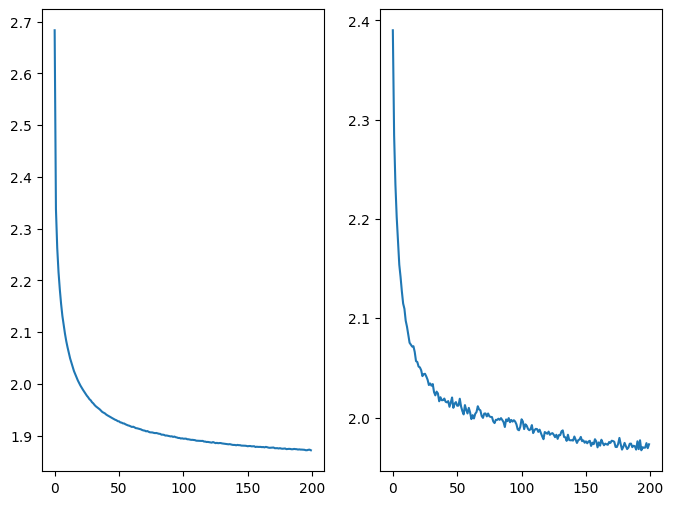

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (8,6))
ax[0].plot(range(0, epochs), train_loss_per_epoch)
ax[1].plot(range(0, epochs), val_loss_per_epoch)

In [50]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.predict(context, max_seq_len=2000, block_size=8)[0].tolist()))



ERCUTIO:
My anoth, presed
If parted,
You wordshall beck
Resit me poddo oavent
Ave his valus head not thee's trup,
My her you woulkienus and must morrow
Clare a low; I dake their fee exes's  on!
If evish glifest many a you blood.

QUEEN ELIFFORGLOUCESTER:
This no land you agay not o' that cruth the loved lear the weet thy stan owas enot givio cappied
Come my lords,
But ever you arsads of deam, rie,
Bathis shade settlefs hat look. Too;
And heart, will thy do.

LAXENCE:
Now am olden are cits fles deell follippies blood, Fir?

WARWINGLOUCESTER:
What honour thy but Beliff all hymes,
But, imbour himself world the not he beein the weress
Inlanguer to our back?
 God doth wear; the ditver I 
pking:
Lest prebus,
Comrown apper; mine to the oar I will, secluseath.
Sincedien to say as the dost an hath his dialtiol.

ANLK:
Not the death she
Of ear, shis folledgence unto your by me,
You ar:
From by plake morrow ta chans
Edward's revering tho Frefore.

CAMILLO:
If is for the very
Call you do voinatu